In [38]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns

          
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")
from IPython.core.display import HTML
HTML("<style>.container {width:80% !important; }</style>")

# Load Original Dataset

In [3]:
originalswitchesdf = pd.read_csv("./Political Party Switches/nova_tabela.csv", header=2, dtype={"mb": np.int32},parse_dates=True )

# clean up original and export
originalswitchesdf.drop(originalswitchesdf[originalswitchesdf.pres_name.isnull() 
                                           & originalswitchesdf.party_id.isnull()].index, axis=0, inplace=1)
originalswitchesdf.mun_id = originalswitchesdf.mun_id.astype(int)
originalswitchesdf.party_id = originalswitchesdf.party_id.astype(int) 
originalswitchesdf.to_csv("./Political Party Switches/changesdf.csv")

switchesdf = originalswitchesdf.copy()

# load party classifications
classificationsdf = pd.read_csv("./Political Party Switches/party_classifications.csv", dtype={"party_id": np.int32}, parse_dates=True)

In [4]:
switchesdf.drop(["prior_party_id","prior_party_name",
                 "appointment"], axis=1, inplace=1, errors="ignore")

switchesdf.drop(switchesdf[switchesdf.pres_name.isnull() & switchesdf.party_id.isnull()].index, axis=0, inplace=1)

In [5]:
switchesdf.date = pd.to_datetime(switchesdf.date, format="%d-%b-%Y")

In [6]:
switchesdf.head(10)

,mun_id,mun,same_person,party_change,pres_name,party_id,party_abr,date
0,70017,Aleksandrovac,1.0,1.0,Jugoslav Stajkovac,46,GGZBZ,2014-06-02
1,70017,Aleksandrovac,1.0,1.0,Jugoslav Stajkovac,4,URS,2013-08-24
2,70017,Aleksandrovac,1.0,0.0,Dragan Blagojevic,1,SNS,2013-03-20
3,70017,Aleksandrovac,0.0,1.0,Dragan Blagojevic,1,SNS,2012-09-17
4,70017,Aleksandrovac,0.0,1.0,Jugoslav Stajkovac,47,GGPZZ,2012-09-05
5,70017,Aleksandrovac,0.0,1.0,Zoran Bojovic,1,SNS,2012-06-01
6,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,2012-05-20
7,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,2008-07-01
8,70025,Aleksinac,0.0,1.0,Nenad Stankovic,1,SNS,2012-07-24
9,70025,Aleksinac,0.0,NaN,Ivan Dimic,7,DSS,2008-12-15


# Expand to panel dataframes

### Daily Panel Data

In [7]:
# daily panel
# initialize panel dataframe 
dpaneldf = pd.DataFrame()

# get all municipalities
mbs = switchesdf.mun_id.unique()

# add panel data from each municipality to main paneldf 
for mb in mbs:
    
    #append a 2016 date
    df = switchesdf[switchesdf.mun_id == mb].append({"mun_id":mb,"mun": "","party_id":-2,
                                           "date":pd.to_datetime("2016-04-03")}, ignore_index=True)
    
    df = df.sort_values("date").set_index("date")
    df = df.asfreq(pd.DateOffset(days=1), method='pad')
    df = df.reset_index()
    dpaneldf = dpaneldf.append(df, ignore_index=True)

In [8]:
print dpaneldf.shape
#dpaneldf.head()

(423329, 8)


In [9]:
dpaneldf = dpaneldf.merge(classificationsdf, on="party_id")

In [10]:
print dpaneldf.shape
dpaneldf.head()

(423174, 27)


,date,mun_id,mun,same_person,party_change,pres_name,party_id,party_abr,name_abr,name_full,opo11,in_gov11,in_gov12,opo13,ingov13,fringe13,ingov14,ag1_name_abr,ag1_party_id,ag1_name_full,ag2_name_abr,ag2_party_id,ag2_name_full,ag3_name_abr,ag3_party_id,ag3_name_full,nat_party
0,2008-07-01,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
1,2008-07-02,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
2,2008-07-03,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
3,2008-07-04,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
4,2008-07-05,70017,Aleksandrovac,1.0,0.0,Jugoslav Stajkovac,47,GGPZZ,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0


In [11]:
#dpaneldf.ag2_name_full.unique()

In [12]:
#dpaneldf.info()

In [13]:
# drop empty column
dpaneldf.drop("party_abr", axis=1,inplace=1, errors='ignore')

# save to csv
dpaneldf.to_csv("./exports/dpaneldf.csv")

### Make Monthly Panel Data

In [14]:
#monthly panel
%time
# define mode function for below
def mode_(s):
    try:
        return s.mode()[0]
    except IndexError:
        return np.nan

# initialize panel dataframe 
mpaneldf = pd.DataFrame()

# get all municipalities
mbs = switchesdf.mun_id.unique()

# add panel data from each municipality to main paneldf 
for mat in mbs:
    
    #append a 2016 date
    df = switchesdf[switchesdf.mun_id == mat].append({"mun_id":mat,"mun": "","party_id":-2,"party_abr":"",
                                           "prior_party_id":-2,"prior_party_name":"",
                                           "date":pd.to_datetime("2016-04-03")}, ignore_index=True)

    # expand to daily values
    df = df.sort_values("date").set_index("date")
    df = df.asfreq(pd.DateOffset(days=1), method='pad')
    
    # collaps to monthly values
    df = df.resample("M", how={"party_id": mode_, 
                               "party_abr": mode_,
                               "mun": mode_, 
                               "mun_id": mode_,
                               "pres_name": mode_})
    df = df.reset_index()
    mpaneldf = mpaneldf.append(df, ignore_index=True)

Wall time: 0 ns


C:\Users\nolefp\Anaconda\lib\site-packages\ipykernel\__main__.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [15]:
print mpaneldf.shape
#mpaneldf.head()

(14103, 6)


In [16]:
mpaneldf = mpaneldf.merge(classificationsdf, on="party_id")

In [17]:
mpaneldf.head()

,date,pres_name,mun,party_id,party_abr,mun_id,name_abr,name_full,opo11,in_gov11,in_gov12,opo13,ingov13,fringe13,ingov14,ag1_name_abr,ag1_party_id,ag1_name_full,ag2_name_abr,ag2_party_id,ag2_name_full,ag3_name_abr,ag3_party_id,ag3_name_full,nat_party
0,2008-07-31,Jugoslav Stajkovac,Aleksandrovac,47.0,GGPZZ,70017.0,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
1,2008-08-31,Jugoslav Stajkovac,Aleksandrovac,47.0,GGPZZ,70017.0,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
2,2008-09-30,Jugoslav Stajkovac,Aleksandrovac,47.0,GGPZZ,70017.0,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
3,2008-10-31,Jugoslav Stajkovac,Aleksandrovac,47.0,GGPZZ,70017.0,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0
4,2008-11-30,Jugoslav Stajkovac,Aleksandrovac,47.0,GGPZZ,70017.0,GGPZZ,"Grupa Gradjana ""Pokret Za Zupu""",0,0,0,0,0,0,0,CG,-2,Citizen Group,LP,-4,Local Party,CG,-2,Citizen Group,0


In [18]:
for col in mpaneldf.columns:
    if re.search("_id", col):
        mpaneldf[col] = mpaneldf[col].astype(int)
#mpaneldf.info()

In [19]:
# drop empty column
mpaneldf.drop("party_abr", axis=1,inplace=1, errors='ignore')

# save to csv
mpaneldf.to_csv("./exports/mpaneldf.csv")

### Annual Panel Data

In [20]:
# annual panel
# define mode function for below

def mode_(s):
    try:
        return s.mode()[0]
    except IndexError:
        return np.nan

# initialize panel dataframe 
apaneldf = pd.DataFrame()

# get all municipalities
mbs = switchesdf.mun_id.unique()

# add panel data from each municipality to main paneldf 
for mat in mbs:
    
    #append a 2016 date
    df = switchesdf[switchesdf.mun_id == mat].append({"mun_id":mat,"mun": "","party_id":-2,"party_abr":"",
                                           "prior_party_id":-2,"prior_party_name":"",
                                           "date":pd.to_datetime("2016-04-03")}, ignore_index=True)

    # expand to daily values
    df = df.sort_values("date").set_index("date")
    df = df.asfreq(pd.DateOffset(days=1), method='pad')
    
    # collaps to monthly values
    df = df.resample("AS", how={"party_id": mode_, 
                               "party_abr": mode_,
                               "mun": mode_, 
                               "mun_id": mode_,
                               "pres_name": mode_})
    df = df.reset_index()
    apaneldf = apaneldf.append(df, ignore_index=True)


C:\Users\nolefp\Anaconda\lib\site-packages\ipykernel\__main__.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [21]:
apaneldf = apaneldf.merge(classificationsdf, on="party_id")

In [22]:
#print apaneldf.info()
#apaneldf.head()

In [23]:
# drop empty column
apaneldf.drop("party_abr", axis=1,inplace=1, errors='ignore')

# save to csv
apaneldf.to_csv("./exports/apaneldf.csv")

In [24]:
#make a connectable apaneldf
apaneldf_connectable = pd.read_csv("./exports/apaneldf.csv")
apaneldf_connectable.date = apaneldf_connectable.date.str.replace("-01-01","").astype(int)
apaneldf_connectable.to_csv("./exports/apaneldf_connectable.csv")

# Visualizations

In [2]:
#Load Data
mpaneldf = pd.read_csv('../Data/exports/mpaneldf.csv')
mpaneldf.date = pd.to_datetime(mpaneldf.date) 

## Party Totals over Time

### Party Changes

'Political_Affiliation_of_Municipality_Presidents_in_Serbia_2012-2016'

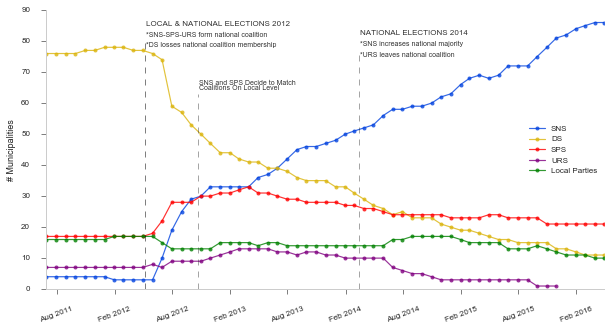

In [86]:
# Special Measures
#graph code
totals_by_party = mpaneldf.groupby(["ag2_name_abr","date"]).mun_id.count().reset_index()

fig, ax = plt.subplots(figsize=(10,5),dpi=300)
#colormap = plt.cm.gist_ncar
#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 15)])

parties_main = ["SNS","DS","SPS","URS","LP"]
colors = [sns.xkcd_rgb["blue"],sns.xkcd_rgb["gold"],"red","purple","green" ] 

# start date from which to plot
start_date = pd.to_datetime("2011-06-01")

for (party, color) in zip(parties_main,colors):
    x= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.ag2_name_abr == party)].date
    y= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.ag2_name_abr == party)].mun_id
   
    plt.plot_date(x,y, 'o-', markersize=4, label=party, color=color,alpha=.8, lw=1.2)

add = 27
sep = 3.5
head = 16
sub = 14

fontscale = .5

#### annotations 
# election 2012
plt.axvline(pd.to_datetime("2012-05-06"),ymax=53./60, ls='dashed', lw=1, color='black', alpha=.5)
plt.text(pd.to_datetime("2012-05-10"),58+add,'Local & National Elections 2012'.upper(), alpha=.8, fontsize=head*fontscale, color='black')
plt.text(pd.to_datetime("2012-05-11"),58-sep+add,'*SNS-SPS-URS form national coalition', alpha=.8, fontsize=sub*fontscale, color='black')
plt.text(pd.to_datetime("2012-05-11"),58-2*sep+add,'*DS losses national coalition membership', alpha=.8, fontsize=sub*fontscale, color='black')

# party matching 2012
plt.axvline(pd.to_datetime("2012-10-23"),ymax=42./60, ls='dashed', lw=.7, color='black', alpha=.5)
plt.text(pd.to_datetime("2012-10-25"),39+add,'SNS and SPS Decide to Match', fontsize=head*fontscale-1, alpha=.8, color='black')
plt.text(pd.to_datetime("2012-10-25"),39-sep/2+add,'Coalitions On Local Level', fontsize=head*fontscale-1, alpha=.8, color='black')


# election 2014
plt.axvline(pd.to_datetime("2014-03-16"),ymax=51.5/60, ls='dashed', lw=.7, color='black', alpha=.5)
plt.text(pd.to_datetime("2014-03-17"),55+add,'National Elections 2014'.upper(), fontsize=head*fontscale, alpha=.8, color='black')
plt.text(pd.to_datetime("2014-03-18"),55-sep+add,'*SNS increases national majority', fontsize=sub*fontscale, alpha=.8, color='black')
plt.text(pd.to_datetime("2014-03-18"),55-2*sep+add,'*URS leaves national coalition', fontsize=sub*fontscale, alpha=.8, color='black')

##### more options
# plot options
title = "Political Affiliation of Municipality Presidents in Serbia 2012-2016"
#plt.title(title)
plt.ylabel("# Municipalities", fontsize=18*fontscale)
plt.grid()
plt.legend(labels=["SNS","DS","SPS","URS","Local Parties"],loc=7, fontsize=16*fontscale)



# axes options
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', direction='out', width=1,length=5,bottom='on',top="off",color='grey')
ax.tick_params(axis='y',which='major', direction='out', width=1,length=5,left='on',right="off",color='grey')
ax.tick_params(axis='y',which='minor', direction='out', width=1,length=3,left='on',right="off",color='grey')
plt.tick_params(axis='both', which='major', labelsize=16*fontscale)
plt.tick_params(axis='both', which='minor', labelsize=14*fontscale)


# rotate x labels
locs, labels = plt.xticks()
plt.setp(labels, rotation=20);  

# save
plt.savefig("./exports/figures/" + title.replace(" ","_"), dpi='figure', bbox_inches='tight', pad_inches=0.0)
plt.savefig("../final paper/" + title.replace(" ","_"), dpi='figure', bbox_inches='tight', pad_inches=0.0)
title.replace(" ","_")

# Additional Analyses

## Party Switching

In [3]:
# table
switches = pd.read_csv("./Political Party Switches/changesdf.csv")
switches.date = pd.to_datetime(switches.date, format="%d-%b-%Y")

# get relevant switches
df = switches[(switches.same_person == 1) & 
         (switches.party_change == 1) & 
         (switches.date > pd.to_datetime("06-may-2012"))].copy()

# make dictionary of switching combinations
party_combos = list(zip(df[["prior_party_name", "party_abr"]].drop_duplicates().prior_party_name, 
                        df[["prior_party_name", "party_abr"]].drop_duplicates().party_abr))

# classify parties as SNS, other incumbent, DS, other opposition, and neutral

def from_party(df):
    temp = (df["prior_party_name"],df["party_abr"]) 
    if temp  in [('VR', 'SNS'), ('PzLP', 'SNS'), 
                                                     ('GGDM', 'SNS'), ('PZJ', 'SNS'), 
                                                     ('GGVM', 'SNS')]:
        return "Independent to SNS"
    
    # deal from URS
    if (df["prior_party_name"] == 'URS'):
        if (df["date"] < pd.to_datetime("2014-03-16")):
            if df["party_abr"] in ['NPS','GGZBZ','PzLP','Nejasna','SNP']:
                return "Other Incumbent to Independent"
            if df["party_abr"] == 'SNS':
                return "Other Incumbent to SNS"
        if (df["date"] > pd.to_datetime("2014-03-16")):
            if df["party_abr"] in ['NPS','GGZBZ','PzLP','Nejasna','SNP']:
                return "URS Independent to Independent"
            if df["party_abr"] == 'SNS':
                return "URS Independent to SNS"  
            
    # deal with to URS
    if (df["party_abr"] == 'URS'):
        if (df["date"] < pd.to_datetime("2014-03-16")):
            if df["prior_party_name"] in ['GGPZZ']:
                return "Independent to Incumbent"
            if df["prior_party_name"] == 'G17+':
                return "G17+ to URS"
            if df["prior_party_name"] == 'DSS':
                return "Opposition to Incumbent"
            
        if (df["date"] > pd.to_datetime("2014-03-16")):
            if df["party_abr"] in ['G17+']:
                return "G17+ to URS"
            if df["prior_party_name"] in ['GGPZZ']:
                return "Independent to URS Independent"
            if df["prior_party_name"] == 'DSS':
                return "Opposition to URS Independent"    

    if temp in [('DSS', 'SNS'), ('DS', 'SNS')]:
        return "Opposition to SNS"
    if temp in [('DS', 'ZzS'), ('DS', 'VS'),('DS', 'GGCB')]:
        return "DS to Independent"
    
    if temp in [('DSS', 'SNP'),('SVM', 'MP')]:
        return "Independent to Independent"

    if temp in [('DS', 'SDS'),('SDS', 'DS')]:
        return "DS-SDS Split"
    if temp == ('NS', 'SNS'):
        return "Incumbent to SNS"
    if temp == ('SPS', 'PS'):
        return "Incumbent to Incumbent"

df["switches_categorized"] = df.apply(from_party, axis=1)

df.switches_categorized.value_counts()

Independent to SNS                6
DS-SDS Split                      6
URS Independent to Independent    5
Opposition to SNS                 3
DS to Independent                 3
Independent to Independent        2
URS Independent to SNS            2
Independent to Incumbent          1
Opposition to Incumbent           1
G17+ to URS                       1
Incumbent to Incumbent            1
Incumbent to SNS                  1
Name: switches_categorized, dtype: int64

In [72]:
df.to_csv('../Data/exports/switches_categorized.csv')

## Switches sorted by Category

In [23]:
switches_appendix = df.sort_values("switches_categorized")[['mun', 'pres_name','party_abr',"prior_party_name", "date", 'switches_categorized']]
print switches_appendix.set_index("mun").to_latex()

\begin{tabular}{llllll}
\toprule
{} &            pres\_name & party\_abr & prior\_party\_name &       date &            switches\_categorized \\
mun               &                      &           &                  &            &                                 \\
\midrule
zabalj            &        Cedomir Bozic &      GGCB &               DS & 2016-02-04 &               DS to Independent \\
Vrsac             &     Cedomir Zivkovic &        VS &               DS & 2012-12-10 &               DS to Independent \\
Sabac             &      Milos Milosevic &       ZzS &               DS & 2014-04-01 &               DS to Independent \\
Bela Palanka      &      Goran Miljkovic &       SDS &               DS & 2014-02-09 &                    DS-SDS Split \\
Novi Knezevac     &         Dragan Babic &       SDS &               DS & 2014-04-15 &                    DS-SDS Split \\
zabalj            &        Cedomir Bozic &       SDS &               DS & 2014-03-15 &                    DS-SDS S

## Presidents with Multiple Switches

In [41]:
multiple = switches_appendix.sort_values(["pres_name", "date"])[switches_appendix.sort_values("pres_name").duplicated("pres_name", keep=False)]
print multiple.set_index("mun").to_latex()

\begin{tabular}{llllll}
\toprule
{} &           pres\_name & party\_abr & prior\_party\_name &       date &            switches\_categorized \\
mun             &                     &           &                  &            &                                 \\
\midrule
zabalj          &       Cedomir Bozic &       SDS &               DS & 2014-03-15 &                    DS-SDS Split \\
zabalj          &       Cedomir Bozic &        DS &              SDS & 2015-02-07 &                    DS-SDS Split \\
zabalj          &       Cedomir Bozic &      GGCB &               DS & 2016-02-04 &               DS to Independent \\
Vrsac           &    Cedomir Zivkovic &        VS &               DS & 2012-12-10 &               DS to Independent \\
Vrsac           &    Cedomir Zivkovic &       SNS &               VR & 2015-11-19 &              Independent to SNS \\
Aleksandrovac   &  Jugoslav Stajkovac &       URS &            GGPZZ & 2013-08-24 &        Independent to Incumbent \\
Aleksandrovac 

C:\Users\nolefp\Anaconda\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


# Pre-Election 2012

In [ ]:
# re-apply names 
inpower_2012_df = inpower_2012_df.merge(classificationsdf, on="party_id")

### sanity check

In [ ]:
inpower_2012_df.head()

In [ ]:
inpower_2012_df.name_abr.value_counts()

In [ ]:
# export the dataframe
inpower_2012_df.to_csv("./Political Party Switches/inpower_preelec_2012.csv")

In [ ]:
"""
# trash code

# make dictionary of switching combinations
dict(zip(zip(df[["prior_party_name", "party_abr"]].drop_duplicates().prior_party_name, 
    df[["prior_party_name", "party_abr"]].drop_duplicates().party_abr), np.zeros(len(df[["prior_party_name", "party_abr"]].drop_duplicates()))))
"""